In [1]:
from mpdaf.obj import Cube
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from astropy import units as u
from numpy import ma

from mpdaf.obj import Image


def bandpass_image(self, wavelengths, sensitivities, unit_wave=u.angstrom,
                       interpolation="linear"):
        """
        bandpass_image sums the images of a cube after multiplying the cube by a given spectral bandpass curve.
        
        
        Given a cube of images versus wavelength and the bandpass
        filter-curve of a wide-band monochromatic instrument, extract
        an image from the cube that has the spectral response of the
        monochromatic instrument.

        For example, this can be used to create a MUSE image that has
        the same spectral characteristics as an HST image. The MUSE
        image can then be compared to the HST image without having to
        worry about any differences caused by different spectral
        sensitivities.

        For each channel n of the cube, the filter-curve is integrated
        over the width of that channel to obtain a weight, w[n]. The
        output image is then given by the following weighted mean::

            output_image = sum(w[n] * cube_image[n]) / sum(w[n])

        In practice, to accommodate masked pixels, the w[n] array is
        expanded into a cube w[n,y,x], and the weights of individual
        masked pixels in the cube are zeroed before the above equation
        is applied.

        If the wavelength axis of the cube only partly overlaps the
        bandpass of the filter-curve, the filter curve is truncated to
        fit within the bounds of the wavelength axis. A warning is
        printed to stderr if this occurs, because this results in an
        image that lacks flux from some of the wavelengths of the
        requested bandpass.

        Parameters
        ----------
        wavelengths : numpy.ndarray
            An array of the wavelengths of the filter curve,
            listed in ascending order of wavelength. Outside
            the listed wavelengths the filter-curve is assumed
            to be zero.
        sensitivities : numpy.ndarray
            The relative flux sensitivities at the wavelengths
            in the wavelengths array. These sensititivies will be
            normalized, so only their relative values are important.
        unit_wave : `astropy.units.Unit`
            The units used in the array of wavelengths. The default is
            angstroms. To specify pixel units, pass None.
        interpolation : str
            The form of interpolation to use to integrate over the
            filter curve. This should be one of::

              "linear"     : Linear interpolation
              "cubic"      : Cubic spline interpolation (very slow)

            The default is linear interpolation. If the filter curve
            is well sampled and its sampling interval is narrower than
            the wavelength pixels of the cube, then this should be
            sufficient. Alternatively, if the sampling interval is
            significantly wider than the wavelength pixels of the
            cube, then cubic interpolation should be used instead.
            Beware that cubic interpolation is much slower than linear
            interpolation.

        Returns
        -------
        `~mpdaf.obj.Image`
            An image formed from the filter-weighted mean of channels in
            the cube that overlap the bandpass of the filter curve.

        """
        from scipy import integrate

        wavelengths = np.asarray(wavelengths, dtype=float)
        sensitivities = np.asarray(sensitivities, dtype=float)

        if (wavelengths.ndim != 1 or sensitivities.ndim != 1 or
                len(wavelengths) != len(sensitivities)):
            raise ValueError('The wavelengths and sensititivies arguments'
                             ' should be 1D arrays of equal length')

        if unit_wave is None:
            pixels = wavelengths.copy()
        else:
            pixels = self.wave.pixel(wavelengths, unit=unit_wave)

        # Get the integer indexes of the pixels that contain the above
        # floating point pixel indexes.
        print(pixels)
        indexes = np.rint(pixels).astype(int)
        print(indexes)

        # If there is no overlap between the bandpass filter curve
        # and the wavelength coverage of the cube, complain.
        if indexes[0] >= self.shape[0] or indexes[-1] < 0:
            raise ValueError("The filter curve does not overlap the "
                             "wavelength coverage of the cube.")

        # To correctly reproduce an image taken through a specified
        # filter, the bandpass curve should be completely encompassed
        # by the wavelength axis of the cube. If the overlap is
        # incomplete, emit a warning, then truncate the bandpass curve
        # to the edge of the wavelength range of the cube.
        if indexes[0] < 0 or indexes[-1] >= self.shape[0]:

            # Work out the start and stop indexes of the slice needed
            # to truncate the arrays of the bandpass filter curve.
            if indexes[0] < 0:
                start = np.searchsorted(indexes, 0, 'left')
            else:
                start = 0
            if indexes[-1] >= self.shape[0]:
                stop = np.searchsorted(indexes, self.shape[0], 'left')
            else:
                stop = indexes.shape[0]

            # Integrate the overal bandpass filter curve.
            total = integrate.trapz(sensitivities, wavelengths)

            # Also integrate over just the truncated parts of the curve.
            lost = 0.0
            if start > 0:
                s = slice(0, start)
                lost += integrate.trapz(sensitivities[s], wavelengths[s])
            if stop < indexes.shape[0]:
                s = slice(stop, indexes.shape[0])
                lost += integrate.trapz(sensitivities[s], wavelengths[s])

            # Compute the fraction of the integrated bandpass response
            # that has been truncated.
            lossage = lost / total

            # Truncate the bandpass filter curve.
            indexes = indexes[start:stop]
            pixels = pixels[start:stop]
            sensitivities = sensitivities[start:stop]

            # Report the loss if it is over 0.5%.
            if lossage > 0.005:
                self._logger.warning(
                    "%.2g%% of the integrated " % (lossage * 100.0) +
                    "filter curve is beyond the edges of the cube.")

        # Get the range of indexes along the wavelength axis that
        # encompass the filter bandpass within the cube.
        kmin = indexes[0]
        kmax = indexes[-1]
        print('Len(k):', kmax - kmin + 1) 
        print(start)
        print(stop)
        print('Subcube k start:', self.wave.coord(kmin))
        print('Subcube k stop:', self.wave.coord(kmax)) #  not sure this is actually how it is being used 
        
        


        # Obtain an interpolator of the bandpass curve.
        spline = interp1d(x=pixels, y=sensitivities,
                                      kind=interpolation)

        # Integrate the bandpass over the range of each spectral pixel
        # to determine the weights of each pixel. For the moment skip
        # the first and last pixels, which need special treatment.
        # Integer pixel indexes refer to the centers of pixels,
        # so for integer pixel index k, we need to integrate from
        # k-0.5 to k+0.5.
        w = np.empty((kmax + 1 - kmin))
        for k in range(kmin + 1, kmax):
            w[k - kmin], err = integrate.quad(spline, k - 0.5, k + 0.5)

        # Start the integration of the weight of the first channel
        # from the lower limit of the bandpass.
        w[0], err = integrate.quad(spline, pixels[0], kmin + 0.5)

        # End the integration of the weight of the final channel
        # at the upper limit of the bandpass.
        w[-1], err = integrate.quad(spline, kmax - 0.5, pixels[-1])

        # Normalize the weights.
        w /= w.sum()

        # Create a sub-cube of the selected channels.
        subcube = self[kmin:kmax + 1, :, :] 

        # To accommodate masked pixels, create a cube of the above
        # weights, but with masked pixels given zero weight.
        if subcube._mask is ma.nomask:
            wcube = w[:, np.newaxis, np.newaxis] * np.ones(subcube.shape)
        else:
            wcube = w[:, np.newaxis, np.newaxis] * ~subcube._mask

        # Get an image which is the sum of the weights along the spectral axis.
        wsum = wcube.sum(axis=0)

        # The output image is the weighted mean of the selected
        # channels. For each map pixel perform the following
        # calculation over spectral channels, k.
        #
        #  mean = sum(weights[k] * data[k]) / sum(weights[k]
        data = np.ma.sum(subcube.data * wcube, axis=0) / wsum

        # The variance of a weighted means is:
        #
        #  var = sum(weights[k]**2 * var[k]) / (sum(weights[k]))**2
        if subcube._var is not None:
            var = np.ma.sum(subcube.var * wcube**2, axis=0) / wsum**2
        else:
            var = False

        return Image.new_from_obj(subcube, data=data, var=var)


In [9]:
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord
import numpy as np

# Load the MUSE cube
cube_fits = fits.open('/Users/s2537809/MUSE/cube_26.fits')
wcs_header = cube_fits[0].header
print(wcs_header)


# Initialize WCS
wcs = WCS(cube_fits[0].header)

# Define the RA and Dec of your source
ra_dec = SkyCoord(ra=150.0, dec=2.30, unit='deg')

# Convert RA and Dec to pixel coordinates (x, y)
x, y = wcs.all_pix2world(ra_dec.ra.deg, ra_dec.dec.deg, 0)




SIMPLE  =                    T / Fits standard                                  BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    3 / Number of axes                                 NAXIS1  =                  409 / Axis length                                    NAXIS2  =                  411 / Axis length                                    NAXIS3  =                 3722 / Axis length                                    EXTEND  =                    F / File may contain extensions                    ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        DATE    = '2024-03-07T10:52:22' / Date FITS file was generated                  IRAF-TLM= '2024-03-07T09:25:26' / Time of last modification                     OBJECT  = 'MUSE-JELS - Pointing 26 (DATA)'                                      CRPIX1  =     215.757034655676 / Pixel coordinate of reference point            CRPIX2  =     193.091925765594 / Pixel c

TypeError: WCS projection has 3 dimensions, so expected 2 (an Nx3 array and the origin argument) or 4 arguments (the position in each dimension, and the origin argument). Instead, 3 arguments were given.

In [2]:

# data array is read from the file (extension number 0)
cube = Cube(filename='/Users/s2537809/MUSE/cube_26.fits')

# The 3 dimensions of the cube:
print('Shape:', cube.shape)

print('Data Shape:', cube.data.shape)

#cube.var.shape - An optional numpy masked array of pixel variances, clearly not in this cube

print('Mask Shape:',cube.mask.shape)


# These output [k,p,q] where k is lamda 

Shape: (3722, 411, 409)
Data Shape: (3722, 411, 409)
Mask Shape: (3722, 411, 409)


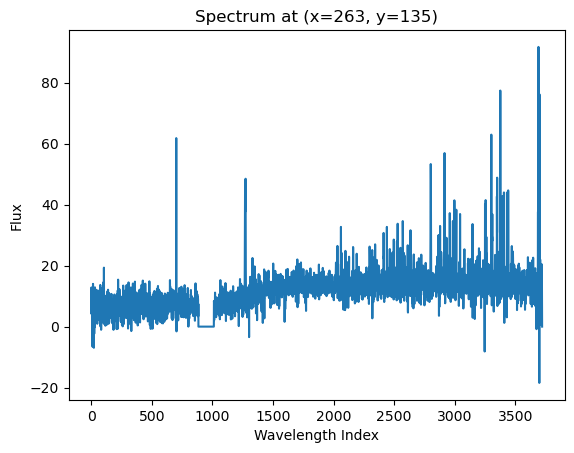

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# Load the MUSE cube
filename = '/Users/s2537809/MUSE/cube_26.fits'
cube_data = fits.getdata(filename, ext=0)  # Reading data from extension 0

# Assuming you have the coordinates (x, y) of the source
x = 263 # Replace with the actual x-coordinate
y = 135  # Replace with the actual y-coordinate

# Extract the 1D spectrum for the given coordinates
spectrum = cube_data[:, y, x]

# Plot the spectrum
plt.plot(spectrum)
plt.xlabel('Wavelength Index')
plt.ylabel('Flux')
plt.title(f'Spectrum at (x={x}, y={y})')
plt.show()



'1e-20 erg/s/cm  2/Angstrom' contains multiple slashes, which is discouraged by the FITS standard


CD1_1 value: 5.55555555555556e-05
Value in arcseconds: 0.20000000000000015 arcsec


[INFO] 3722 Spectrum (no name)
[INFO] .data(3722) (no unit), no noise
[INFO] wavelength: min:4700.33 max:9351.58 step:1.25 Angstrom


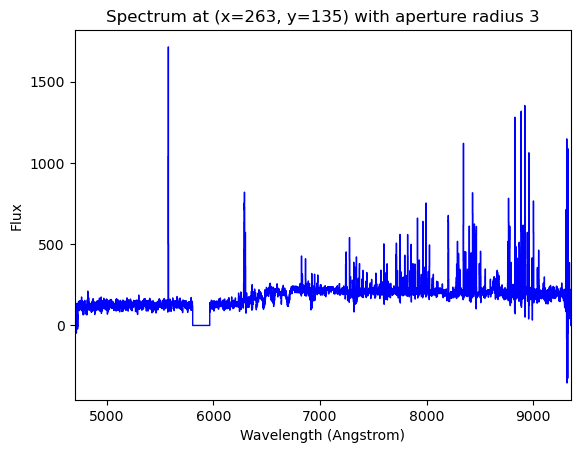

In [25]:

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from mpdaf.obj import Spectrum, WaveCoord, Cube

# Load the MUSE data cube using mpdaf
filename = '/Users/s2537809/MUSE/cube_26.fits'
cube = Cube(filename)

with fits.open(filename) as hdulist:
    im_data = hdulist[0].data
    header = hdulist[0].header

# Extract WCS  information
im_wcs = WCS(header)

# Get cd object
cd_matrix = im_wcs.wcs.cd


# Extract the CD1_1 value
cd1_1 = abs(cd_matrix[0, 0])

print("CD1_1 value:", cd1_1)

# Unit conversion to arcseconds
pixscale_deg = cd1_1 * u.deg
pixscale_arcs = pixscale_deg.to(u.arcsec)

print("Value in arcseconds:", pixscale_arcs)

# Calculate the pixscale for Nyquist sampling (2 times the pixel scale)
pixscale_nyquist = 2 * pixscale_arcs


# Specify the coordinates of the source (in pixel coordinates)
x_center = 263  # Replace with the actual x-coordinate
y_center = 135  # Replace with the actual y-coordinate

# Specify the aperture radius (in pixels) or just use a single pixel if you want
aperture_radius = 3  # Adjust as needed

aperture_area_arcsec2 = np.pi * (aperture_radius_arcsec**2)
print(f"Aperture area in arcseconds²: {aperture_area_arcsec2:.2f}")

# Extract data within the aperture
# Create a simple mask for a circular aperture
ny, nx = cube.shape[1], cube.shape[2]
y, x = np.ogrid[:ny, :nx]
dist_from_center = np.sqrt((x - x_center)**2 + (y - y_center)**2)
mask = dist_from_center <= aperture_radius

# Apply the mask and sum over the spatial dimensions
flux_data = np.sum(cube.data[:, mask], axis=1)


# Convert flux to flux density (per arcsecond squared)
flux_density = flux_data / aperture_area_arcsec2

# Create the wavelength coordinates
wave = cube.wave

# Create a Spectrum object with flux density
spectrum = Spectrum(wave=wave, data=flux_density)


# Handle variance (optional): sum variances within the aperture
# Uncomment if your cube has a variance array
# variance_data = np.sum(cube.var[:, mask], axis=1)

# Create the wavelength coordinates
wave = cube.wave

# Create a Spectrum object
spectrum = Spectrum(wave=wave, data=flux_data)

# Print spectrum information
spectrum.info()

# Plot the spectrum
plt.figure()
spectrum.plot(color='b')
plt.title(f'Spectrum at (x={x_center}, y={y_center}) with aperture radius {aperture_radius}')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux')
plt.show()




In [61]:
# Open the FITS file
filename = '/Users/s2537809/MUSE/cube_27.fits'
with fits.open(filename) as hdulist:
    header = hdulist[0].header

# Print header information
for key in header.keys():
    print(f"{key}: {header[key]}")

SIMPLE: True
BITPIX: -32
NAXIS: 3
NAXIS1: 407
NAXIS2: 407
NAXIS3: 3722
EXTEND: False
ORIGIN: NOAO-IRAF FITS Image Kernel July 2003
DATE: 2024-03-07T15:30:27
IRAF-TLM: 2024-03-07T13:50:30
OBJECT: MUSE-JELS - Pointing 27 (DATA)
CRPIX1: 217.274132813723
CRPIX2: 192.047166336381
CD1_1: -5.55555555555556e-05
CD2_2: 5.55555555555556e-05
CUNIT1: deg
CUNIT2: deg
CTYPE1: RA---TAN
CTYPE2: DEC--TAN
CSYER1: 1.73994402498e-05
CSYER2: 9.0407266362e-06
CRVAL1: 150.086717
CRVAL2: 2.31701
CTYPE3: AWAV
CUNIT3: Angstrom
CD3_3: 1.25
CRPIX3: 1.0
CRVAL3: 4700.4345703125
HDUCLASS: ESO
HDUDOC: DICD
HDUVERS: DICD version 6
HDUCLAS1: IMAGE
HDUCLAS2: DATA
ERRDATA: STAT
BUNIT: 10**(-20)*erg/s/cm**2/Angstrom
CHECKSUM: HEIoKBHoHBHoHBHo
DATASUM: 1552190426
WCSDIM: 3
LTV1: 22.0
LTV2: 4.0
LTM1_1: 1.0
LTM2_2: 1.0
LTM3_3: 1.0
WAT0_001: system=image
WAT1_001: wtype=tan axtype=ra
WAT2_001: wtype=tan axtype=dec
WAT3_001: label=awav
IMCMB001: DATACUBE_FINAL3688185a_1.fits[1]
IMCMB002: DATACUBE_FINAL3688185a_2.fits[1]
IMCMB0

Pixel scale in arcseconds/pixel: 0.20000000000000015 arcsec
Aperture radius: 0.60 arcseconds, which is 3.00 pixels
Aperture area in arcseconds^2: 1.13


[INFO] 3722 Spectrum (no name)
[INFO] .data(3722) (no unit), no noise
[INFO] wavelength: min:4700.33 max:9351.58 step:1.25 Angstrom


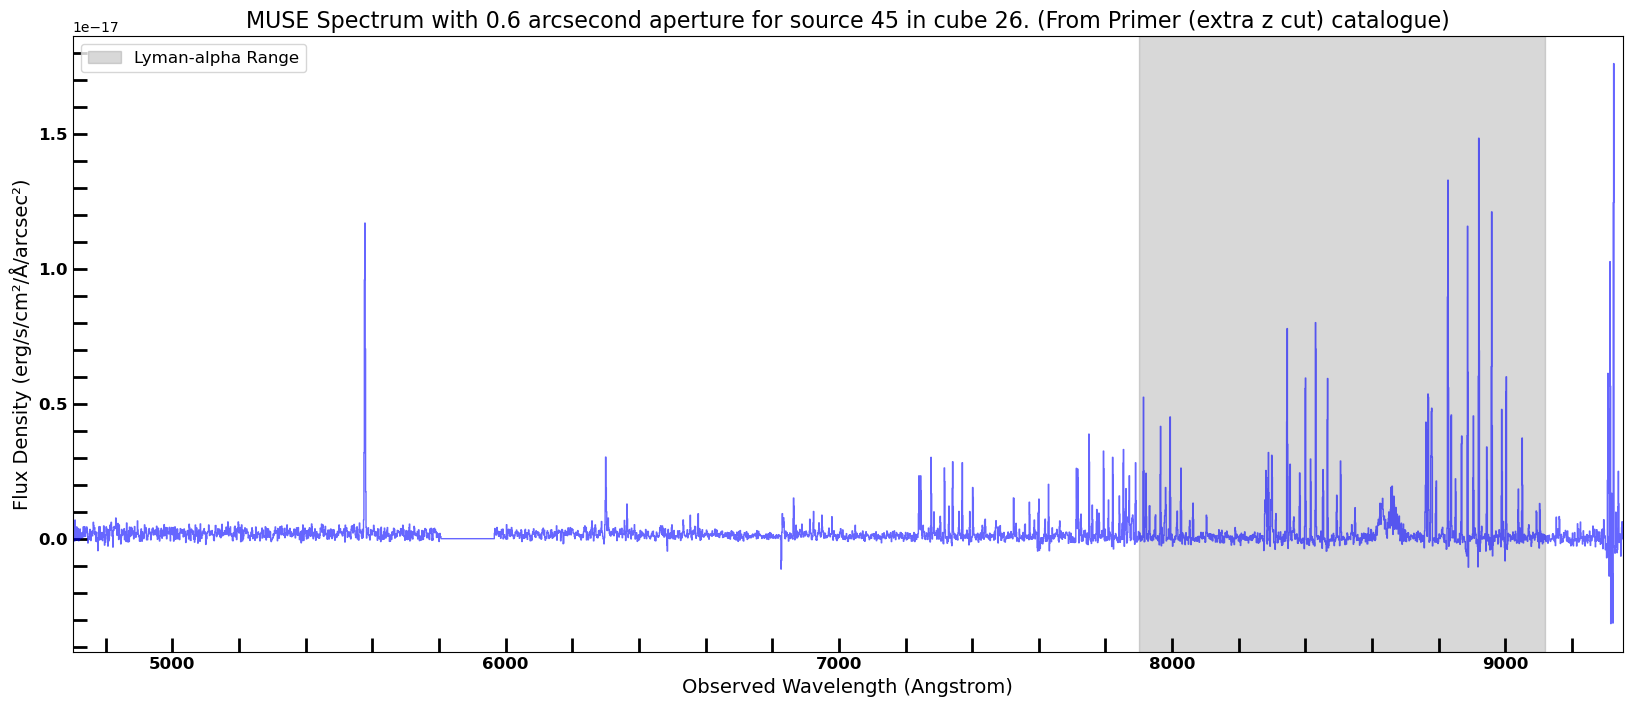

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from mpdaf.obj import Spectrum, Cube

cube_no = '26'
match = 'Primer (extra z cut)'
# Specify the coordinates of the source (in pixel coordinates)
x_center = 309
y_center = 271
#ra_center = 
#dec_center =
cat2_label = '45'

# Specify the aperture radius (in arcseconds)
aperture_radius_arcsec = 0.6 

# Load the MUSE data cube using mpdaf
filename = f'/Users/s2537809/MUSE/cube_{cube_no}.fits'
cube = Cube(filename)

with fits.open(filename) as hdulist:
    header = hdulist[0].header

# Extract WCS information
im_wcs = WCS(header)

# Use the middle wavelength value of the cube for the 3rd dimension
wavelength_center = cube.wave.coord()

# Convert RA, Dec, and wavelength to pixel coordinates
#pixel_coords = im_wcs.wcs_world2pix(ra_center, dec_center, wavelength_center, 0)

#x_center = int(pixel_coords[0][0])
#y_center = int(pixel_coords[1][0])

# Get cd matrix
cd_matrix = im_wcs.wcs.cd

# Extract the CD1_1 value (pixel scale in degrees/pixel)
cd1_1 = abs(cd_matrix[0, 0])

# Convert pixel scale to arcseconds/pixel
pixscale_arcs = (cd1_1 * u.deg).to(u.arcsec)
pixscale_arcs_value = pixscale_arcs.value

print("Pixel scale in arcseconds/pixel:", pixscale_arcs)

# Convert aperture radius from arcseconds to pixels
aperture_radius_pixels = aperture_radius_arcsec / pixscale_arcs_value
print(f"Aperture radius: {aperture_radius_arcsec:.2f} arcseconds, which is {aperture_radius_pixels:.2f} pixels")


aperture_area_arcsec2 = np.pi * (aperture_radius_arcsec**2)
print(f"Aperture area in arcseconds^2: {aperture_area_arcsec2:.2f}")

# Extract data within the aperture
# Create a simple mask for a circular aperture
ny, nx = cube.shape[1], cube.shape[2]
y, x = np.ogrid[:ny, :nx]
dist_from_center = np.sqrt((x - x_center)**2 + (y - y_center)**2)
mask = dist_from_center <= aperture_radius_pixels

# Apply the mask and sum over the spatial dimensions
flux_data = np.sum(cube.data[:, mask], axis=1)

# Flux is in 10**(-20) erg/s/cm²/Å
# Convert flux to flux density (per arcsecond squared)
flux_density = (flux_data / aperture_area_arcsec2)*10**(-20)

# Create the wavelength coordinates
wave = cube.wave

# Create a Spectrum object with flux density
spectrum = Spectrum(wave=wave, data=flux_density)

# Print spectrum information
spectrum.info()


# Define the redshift range
z_min = 5.5
z_max = 6.5

# Rest-frame wavelength of Lyman-alpha
lyman_alpha_rest = 1215.67  # in Angstroms

# Calculate observed wavelength range
lyman_alpha_obs_min = lyman_alpha_rest * (1 + z_min)
lyman_alpha_obs_max = lyman_alpha_rest * (1 + z_max)

# Enhanced Plotting
plt.figure(figsize=(20, 8))
spectrum.plot(color='b', linestyle='-', marker='', alpha=0.6)

# Add grey shaded area for Lyman-alpha range
plt.axvspan(lyman_alpha_obs_min, lyman_alpha_obs_max, color='grey', alpha=0.3, label='Lyman-alpha Range')

# Customize the plot further
plt.xlabel('Observed Wavelength (Angstrom)', fontsize=14)
plt.ylabel('Flux Density (erg/s/cm²/Å/arcsec²)', fontsize=14)
plt.title(f'MUSE Spectrum with {aperture_radius_arcsec} arcsecond aperture for source {cat2_label} in cube {cube_no}. (From {match} catalogue)', fontsize=16)
plt.minorticks_on()
plt.tick_params(axis='both', which='both', direction='in', length=10, width=2, colors='black', grid_color='black', grid_alpha=0.5)
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')
#plt.xlim(8000,9000)
plt.legend(fontsize=12)  # Add legend to identify the shaded area

# Show the plot
plt.show()

# Save plot
#plt.savefig(f'/Users/s2537809/MUSE/Spectra/source{cat2_label}_cube{cube_no}_cat_{match}.png')


In [23]:
import numpy as np
from mpdaf.obj import Cube

# Load the cube
cube = Cube('/Users/s2537809/MUSE/cube_26.fits')

# Calculate the variance along the spectral dimension (axis=0)
# This gives you a 2D variance for each spatial pixel across the spectral dimension
variance_2d = np.var(cube.data, axis=0)

# Expand the 2D variance to match the 3D shape by duplicating it across the spectral dimension
# This assumes that the variance is the same across all spectral slices
variance_3d = np.repeat(variance_2d[np.newaxis, :, :], cube.data.shape[0], axis=0)

# Assign the computed variance to the cube
cube.var = variance_3d

# Save the cube with the variance to a new FITS file if needed
cube.write('/Users/s2537809/MUSE/cube_26_with_variance.fits')



In [1]:

from mpdaf.sdetect import muselet
muselet(f'/Users/s2537809/MUSE/cube_26_with_variance.fits', step=1)



[DEBUG] No exposure cube provided
[INFO] STEP 1: create white light, variance, RGB and narrow-band images
[INFO] creating broad-band images
[DEBUG] writing white light image: /Users/s2537809/MUSE/im_white.fits
[INFO] calculating weight image from variance cube
[DEBUG] writing weight image: /Users/s2537809/MUSE/im_weight.fits
[DEBUG] writing blue image: /Users/s2537809/MUSE/im_b.fits
[DEBUG] writing green image: /Users/s2537809/MUSE/im_g.fits
[DEBUG] writing red image: /Users/s2537809/MUSE/im_r.fits
[INFO] creating narrow-band images using 1 CPU


Created:3717/3717

[DEBUG] writing narrow-band cube: /Users/s2537809/MUSE/NB_cube_26_with_variance.fits
[INFO] STEP 2: run SExtractor on broad-band and narrow-band images
[DEBUG] [/opt/homebrew/bin/sex] SExtractor version 2.28.0 (2023-03-11)
[INFO] running SExtractor on white light and RGB images
[DEBUG] combining catalogs
[INFO] 57 continiuum objects detected
[DEBUG] writing catalog: /Users/s2537809/MUSE/cat_bgr.dat
[INFO] running SExtractor on narrow-band images using 1 CPU


SExtractor:3717/3717

[INFO] STEP 3: merge SExtractor catalogs and measure redshifts
[DEBUG] excluding wavelengths between 5573.50Å and 5578.80Å
[DEBUG] excluding wavelengths between 6297.00Å and 6300.50Å
[DEBUG] 7 narrow-band layers will be excluded
[INFO] loading narrow-band catalogs using 1 CPU


Loaded:82/3710

[WARNING] ID 13, not found in seg0084.fits


Loaded:84/3710

[WARNING] ID 16, not found in seg0086.fits


Loaded:112/3710

[WARNING] ID 18, not found in seg0114.fits


Loaded:118/3710

[WARNING] ID 19, not found in seg0120.fits


Loaded:755/3710

[WARNING] ID 6, not found in seg0761.fits


Loaded:2146/3710

[WARNING] ID 10, not found in seg2155.fits


Loaded:2847/3710

[WARNING] ID 4, not found in seg2856.fits


Loaded:2864/3710

[WARNING] ID 9, not found in seg2873.fits


Loaded:3163/3710

[WARNING] ID 7, not found in seg3172.fits


Loaded:3710/3710

[DEBUG] combining catalogs
[INFO] 57541 raw detections found


[INFO] cleaning detections with fluxes below 5σ
[INFO] 42746 detections remain (14795 removed)
[INFO] cleaning detections at edge of cube
[INFO] 12226 detections remain (30520 removed)
[INFO] cleaning below image weight 0.03273841366171837
[INFO] 12009 detections remain (217 removed)
[DEBUG] merging raw detections within Δr < 0.80″ and Δλ < 3.75Å
[INFO] 6090 lines found (5919 duplicate detections discarded)
[DEBUG] grouping lines within Δr < 0.80″
[DEBUG] group assignment converged after 19 iterations
[INFO] 1668 objects found
[DEBUG] writing raw catalog: /Users/s2537809/MUSE/cat_raw.fit
[DEBUG] writing cleaned catalog: /Users/s2537809/MUSE/cat_raw-clean.fit
[DEBUG] writing line catalog: /Users/s2537809/MUSE/cat_lines.fit
[DEBUG] writing object catalog: /Users/s2537809/MUSE/cat_objects.fit
[INFO] creating line source files using 1 CPU
[DEBUG] writing sources to: /Users/s2537809/MUSE/lines


Created:6090/6090

[INFO] creating line source catalog
[INFO] Building catalog from path /Users/s2537809/MUSE/lines


 100%

[DEBUG] writing catalog to: /Users/s2537809/MUSE/lines.fit


[INFO] creating object source files using 1 CPU
[DEBUG] writing sources to: /Users/s2537809/MUSE/objects


Created:1668/1668

[INFO] creating object source catalog
[INFO] Building catalog from path /Users/s2537809/MUSE/objects


 100%

[DEBUG] writing catalog to: /Users/s2537809/MUSE/objects.fit


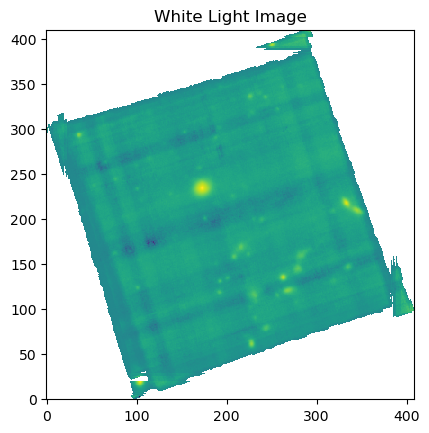

In [12]:
# import Image 
from mpdaf.obj import Image
import matplotlib.pyplot as plt

from mpdaf.sdetect import Catalog
cat_lines = Catalog.read('lines.fit')
cat_objects = Catalog.read('objects.fit')




# Load the white light image
image = Image('/Users/s2537809/MUSE/im_white.fits')

# Display the image
image.plot(scale='log', cmap='viridis', title='White Light Image')
plt.show()



In [6]:
cat_objects

ID,RA,DEC,FROM,FROM_V,CUBE,CUBE_V,SRC_V,FORMAT,MUSEB,MUSEB_ERR,MUSEG,MUSEG_ERR,MUSER,MUSER_ERR,Z_EMI,Z_EMI_MAX,Z_EMI_MIN,FLUX001,FLUX_ERR001,LBDA_OBS001,LBDA_OBS_ERR001,LINE001,FLUX002,FLUX_ERR002,LBDA_OBS002,LBDA_OBS_ERR002,LINE002,FLUX003,FLUX_ERR003,LBDA_OBS003,LBDA_OBS_ERR003,LINE003,FLUX004,FLUX_ERR004,LBDA_OBS004,LBDA_OBS_ERR004,LINE004,FLUX005,FLUX_ERR005,LBDA_OBS005,LBDA_OBS_ERR005,LINE005,FLUX006,FLUX_ERR006,LBDA_OBS006,LBDA_OBS_ERR006,LINE006,FLUX007,FLUX_ERR007,LBDA_OBS007,LBDA_OBS_ERR007,LINE007,FLUX008,FLUX_ERR008,LBDA_OBS008,LBDA_OBS_ERR008,LINE008,FLUX009,FLUX_ERR009,LBDA_OBS009,LBDA_OBS_ERR009,LINE009,FLUX010,FLUX_ERR010,LBDA_OBS010,LBDA_OBS_ERR010,LINE010,FLUX011,FLUX_ERR011,LBDA_OBS011,LBDA_OBS_ERR011,LINE011,FLUX012,FLUX_ERR012,LBDA_OBS012,LBDA_OBS_ERR012,LINE012,FLUX013,FLUX_ERR013,LBDA_OBS013,LBDA_OBS_ERR013,LINE013,FLUX014,FLUX_ERR014,LBDA_OBS014,LBDA_OBS_ERR014,LINE014,FLUX015,FLUX_ERR015,LBDA_OBS015,LBDA_OBS_ERR015,LINE015,FLUX016,FLUX_ERR016,LBDA_OBS016,LBDA_OBS_ERR016,LINE016,FLUX017,FLUX_ERR017,LBDA_OBS017,LBDA_OBS_ERR017,LINE017,FLUX018,FLUX_ERR018,LBDA_OBS018,LBDA_OBS_ERR018,LINE018,FLUX019,FLUX_ERR019,LBDA_OBS019,LBDA_OBS_ERR019,LINE019,FLUX020,FLUX_ERR020,LBDA_OBS020,LBDA_OBS_ERR020,LINE020,FLUX021,FLUX_ERR021,LBDA_OBS021,LBDA_OBS_ERR021,LINE021,FLUX022,FLUX_ERR022,LBDA_OBS022,LBDA_OBS_ERR022,LINE022,FLUX023,FLUX_ERR023,LBDA_OBS023,LBDA_OBS_ERR023,LINE023,FLUX024,FLUX_ERR024,LBDA_OBS024,LBDA_OBS_ERR024,LINE024,FLUX025,FLUX_ERR025,LBDA_OBS025,LBDA_OBS_ERR025,LINE025,FILENAME
,deg,deg,,,,,,,mag,mag,mag,mag,mag,mag,,,,1e-20 erg / (Angstrom s cm2),1e-20 erg / (Angstrom s cm2),Angstrom,Angstrom,,1e-20 erg / (Angstrom s cm2),1e-20 erg / (Angstrom s cm2),Angstrom,Angstrom,,1e-20 erg / (Angstrom s cm2),1e-20 erg / (Angstrom s cm2),Angstrom,Angstrom,,1e-20 erg / (Angstrom s cm2),1e-20 erg / (Angstrom s cm2),Angstrom,Angstrom,,1e-20 erg / (Angstrom s cm2),1e-20 erg / (Angstrom s cm2),Angstrom,Angstrom,,1e-20 erg / (Angstrom s cm2),1e-20 erg / (Angstrom s cm2),Angstrom,Angstrom,,1e-20 erg / (Angstrom s cm2),1e-20 erg / (Angstrom s cm2),Angstrom,Angstrom,,1e-20 erg / (Angstrom s cm2),1e-20 erg / (Angstrom s cm2),Angstrom,Angstrom,,1e-20 erg / (Angstrom s cm2),1e-20 erg / (Angstrom s cm2),Angstrom,Angstrom,,1e-20 erg / (Angstrom s cm2),1e-20 erg / (Angstrom s cm2),Angstrom,Angstrom,,1e-20 erg / (Angstrom s cm2),1e-20 erg / (Angstrom s cm2),Angstrom,Angstrom,,1e-20 erg / (Angstrom s cm2),1e-20 erg / (Angstrom s cm2),Angstrom,Angstrom,,1e-20 erg / (Angstrom s cm2),1e-20 erg / (Angstrom s cm2),Angstrom,Angstrom,,1e-20 erg / (Angstrom s cm2),1e-20 erg / (Angstrom s cm2),Angstrom,Angstrom,,1e-20 erg / (Angstrom s cm2),1e-20 erg / (Angstrom s cm2),Angstrom,Angstrom,,1e-20 erg / (Angstrom s cm2),1e-20 erg / (Angstrom s cm2),Angstrom,Angstrom,,1e-20 erg / (Angstrom s cm2),1e-20 erg / (Angstrom s cm2),Angstrom,Angstrom,,1e-20 erg / (Angstrom s cm2),1e-20 erg / (Angstrom s cm2),Angstrom,Angstrom,,1e-20 erg / (Angstrom s cm2),1e-20 erg / (Angstrom s cm2),Angstrom,Angstrom,,1e-20 erg / (Angstrom s cm2),1e-20 erg / (Angstrom s cm2),Angstrom,Angstrom,,1e-20 erg / (Angstrom s cm2),1e-20 erg / (Angstrom s cm2),Angstrom,Angstrom,,1e-20 erg / (Angstrom s cm2),1e-20 erg / (Angstrom s cm2),Angstrom,Angstrom,,1e-20 erg / (Angstrom s cm2),1e-20 erg / (Angstrom s cm2),Angstrom,Angstrom,,1e-20 erg / (Angstrom s cm2),1e-20 erg / (Angstrom s cm2),Angstrom,Angstrom,,1e-20 erg / (Angstrom s cm2),1e-20 erg / (Angstrom s cm2),Angstrom,Angstrom,,
int64,float64,float64,bytes7,bytes3,bytes21,bytes1,bytes1,bytes3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes20,float64,float64,float64,float64,bytes20,float64,float64,float64,float64,bytes20,float64,float64,float64,float64,bytes20,float64,float64,float64,float64,bytes20,float64,float64,float64,float64,bytes20,float64,float64,float64,float64,bytes20,float64,float64,float64,float64,bytes20,float64,float64,float64,float64,bytes20,float

In [3]:
from mpdaf.sdetect import SourceList
sources_lines = SourceList.from_path('lines')
sources_objects = SourceList.from_path('objects')

In [131]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from mpdaf.obj import Spectrum, Cube

cube_no = '26'
match = 'Primer (extra z cut)'

# Specify the coordinates of the source (in RA and Dec)
ra_center = 150.10522574429797  # Replace with the actual RA in degrees
dec_center = 2.313908771623179  # Replace with the actual Dec in degrees
cat2_label = '33'

# Specify the aperture radius (in arcseconds)
aperture_radius_arcsec = 0.6 

# Load the MUSE data cube using mpdaf
filename = f'/Users/s2537809/MUSE/cube_{cube_no}.fits'
cube = Cube(filename)

with fits.open(filename) as hdulist:
    header = hdulist[0].header

# Extract WCS information
im_wcs = WCS(header)

# Use the middle wavelength value of the cube for the 3rd dimension
wavelength_center = cube.wave.coord()

# Convert RA, Dec, and wavelength to pixel coordinates
pixel_coords = im_wcs.wcs_world2pix(ra_center, dec_center, wavelength_center, 0)

x_center = int(pixel_coords[0][0])
y_center = int(pixel_coords[1][0])

'1e-20 erg/s/cm  2/Angstrom' contains multiple slashes, which is discouraged by the FITS standard


In [105]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from mpdaf.obj import Spectrum, Cube

cube_no = '28'
match = 'Primer (extra z cut)'

# Specify the coordinates of the source (in RA and Dec)
ra_center = 150.015625  # Replace with the actual RA in degrees
dec_center = 2.20069444  # Replace with the actual Dec in degrees
cat2_label = '33'

# Specify the aperture radius (in arcseconds)
aperture_radius_arcsec = 0.6 

# Load the MUSE data cube using mpdaf
filename = f'/Users/s2537809/MUSE/cube_{cube_no}.fits'
cube = Cube(filename)

with fits.open(filename) as hdulist:
    header = hdulist[0].header

# Extract WCS information
im_wcs = WCS(header)

# Use the middle wavelength value of the cube for the 3rd dimension
wavelength_center = cube.wave.coord()

# Convert RA, Dec, and wavelength to pixel coordinates
pixel_coords = im_wcs.wcs_world2pix(ra_center, dec_center, wavelength_center, 0)

# Ensure x_center and y_center are scalars
x_center, y_center = pixel_coords[0], pixel_coords[1]
print(f"RA: {ra_center} deg, Dec: {dec_center} deg -> Pixel coordinates: x={x_center}, y={y_center}")

# Get cd matrix
cd_matrix = im_wcs.wcs.cd

# Extract the CD1_1 value (pixel scale in degrees/pixel)
cd1_1 = abs(cd_matrix[0, 0])

# Convert pixel scale to arcseconds/pixel
pixscale_arcs = (cd1_1 * u.deg).to(u.arcsec)
pixscale_arcs_value = pixscale_arcs.value

print("Pixel scale in arcseconds/pixel:", pixscale_arcs)

# Convert aperture radius from arcseconds to pixels
aperture_radius_pixels = aperture_radius_arcsec / pixscale_arcs_value
print(f"Aperture radius: {aperture_radius_arcsec:.2f} arcseconds, which is {aperture_radius_pixels:.2f} pixels")

aperture_area_arcsec2 = np.pi * (aperture_radius_arcsec**2)
print(f"Aperture area in arcseconds^2: {aperture_area_arcsec2:.2f}")

# Extract data within the aperture
# Create a simple mask for a circular aperture
ny, nx = cube.shape[1], cube.shape[2]
y, x = np.ogrid[:ny, :nx]
dist_from_center = np.sqrt((x - x_center)**2 + (y - y_center)**2)
mask = dist_from_center <= aperture_radius_pixels

# Apply the mask and sum over the spatial dimensions
flux_data = np.sum(cube.data[:, mask], axis=1)

# Flux is in 10**(-20) erg/s/cm²/Å
# Convert flux to flux density (per arcsecond squared)
flux_density = (flux_data / aperture_area_arcsec2) * 10**(-20)

# Create the wavelength coordinates
wave = cube.wave

# Create a Spectrum object with flux density
spectrum = Spectrum(wave=wave, data=flux_density)

# Print spectrum information
spectrum.info()

# Define the redshift range
z_min = 5.5
z_max = 6.5

# Rest-frame wavelength of Lyman-alpha
lyman_alpha_rest = 1215.67  # in Angstroms

# Calculate observed wavelength range
lyman_alpha_obs_min = lyman_alpha_rest * (1 + z_min)
lyman_alpha_obs_max = lyman_alpha_rest * (1 + z_max)

# Enhanced Plotting
plt.figure(figsize=(20, 8))
spectrum.plot(color='b', linestyle='-', marker='', alpha=0.6)

# Add grey shaded area for Lyman-alpha range
plt.axvspan(lyman_alpha_obs_min, lyman_alpha_obs_max, color='grey', alpha=0.3, label='Lyman-alpha Range')

# Customize the plot further
plt.xlabel('Observed Wavelength (Angstrom)', fontsize=14)
plt.ylabel('Flux Density (10⁻²⁰ erg/s/cm²/Å/arcsec²)', fontsize=14)
plt.title(f'MUSE Spectrum with {aperture_radius_arcsec} arcsecond aperture for source {cat2_label} in cube {cube_no}. (From {match} catalogue)', fontsize=16)
plt.minorticks_on()
plt.tick_params(axis='both', which='both', direction='in', length=10, width=2, colors='black', grid_color='black', grid_alpha=0.5)
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')
#plt.xlim(8500,9000)
plt.legend(fontsize=12)  # Add legend to identify the shaded area

# Show the plot
plt.show()

# Save plot
#plt.savefig(f'/Users/s2537809/MUSE/Spectra/source{cat2_label}_cube{cube_no}_cat_{match}.png')


RA: 150.015625 deg, Dec: 2.20069444 deg -> Pixel coordinates: x=[1236.3722221 1236.3722221 1236.3722221 ... 1236.3722221 1236.3722221
 1236.3722221], y=[-1982.61920777 -1982.61920777 -1982.61920777 ... -1982.61920777
 -1982.61920777 -1982.61920777]
Pixel scale in arcseconds/pixel: 0.20000000000000015 arcsec
Aperture radius: 0.60 arcseconds, which is 3.00 pixels
Aperture area in arcseconds^2: 1.13


'1e-20 erg/s/cm  2/Angstrom' contains multiple slashes, which is discouraged by the FITS standard


ValueError: operands could not be broadcast together with shapes (1,409) (3722,) 

[INFO] 411 x 409 Image (/Users/s2537809/MUSE/cube_26.fits)
[INFO] .data(411 x 409) (1e-20 erg / (Angstrom s cm2)), no noise
[INFO] center:(02:18:47.11361439,10:00:24.41354409) size:(82.200",81.800") step:(0.200",0.200") rot:-0.0 deg frame:ICRS


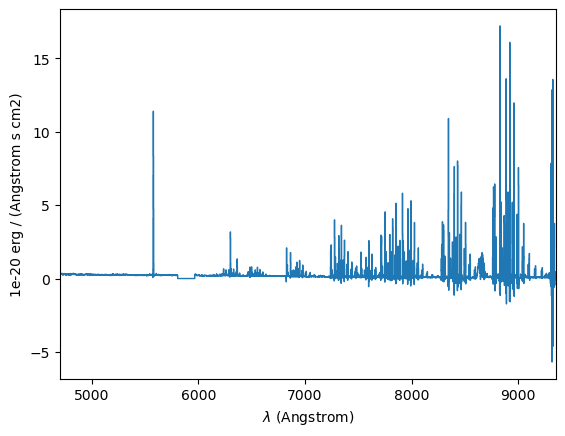

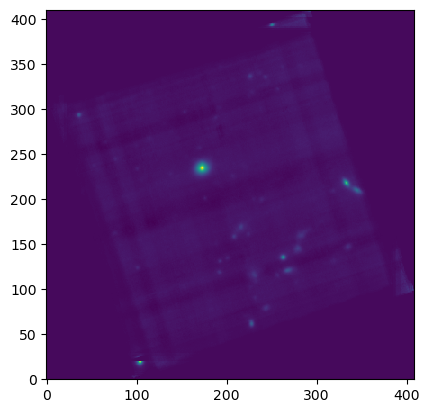

In [111]:
spe = cube.mean(axis=(1,2))

spe.plot()

ima = cube.mean(axis=0)  #white image if sum - if its mean can add weights axis zero is wavelengths 

ima.info()


plt.figure()

ima.plot()

In [123]:
cube[3000,300,300] # can call any pixel in the cube

ima1 = cube[2000, :, :]

ima1

<Image(shape=(411, 409), unit='1e-20 erg / (Angstrom s cm2)', dtype='float64')>

<Figure size 640x480 with 0 Axes>

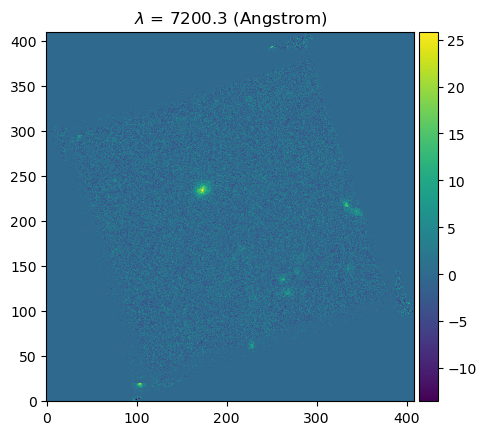

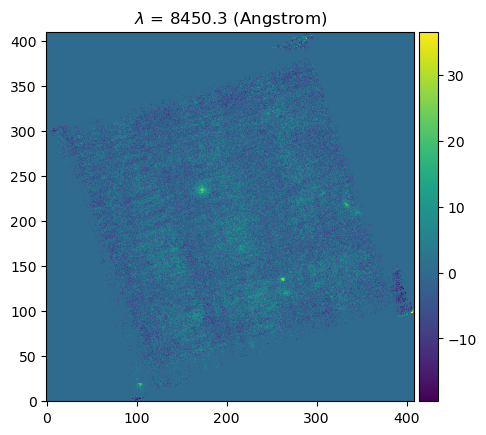

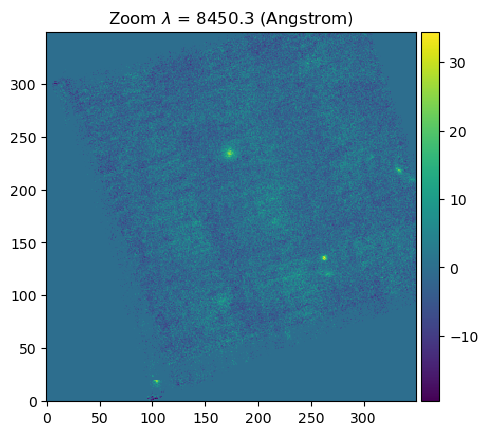

<Figure size 640x480 with 0 Axes>

In [105]:
ima1 = cube[2000, :, :]

plt.figure()


ima1.plot(colorbar='v', title = '$\lambda$ = %.1f (%s)' %(cube.wave.coord(2000), cube.wave.unit))

ima2 = cube[3000, :, :]

plt.figure()


ima2.plot(colorbar='v', title = '$\lambda$ = %.1f (%s)' %(cube.wave.coord(3000), cube.wave.unit))


plt.figure()


ima2[0:350, 0:350].plot(colorbar='v',title = 'Zoom $\lambda$ = %.1f (%s)' %(cube.wave.coord(3000), cube.wave.unit))




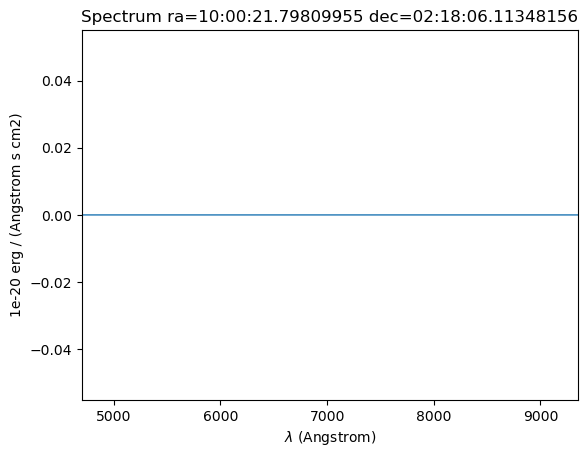

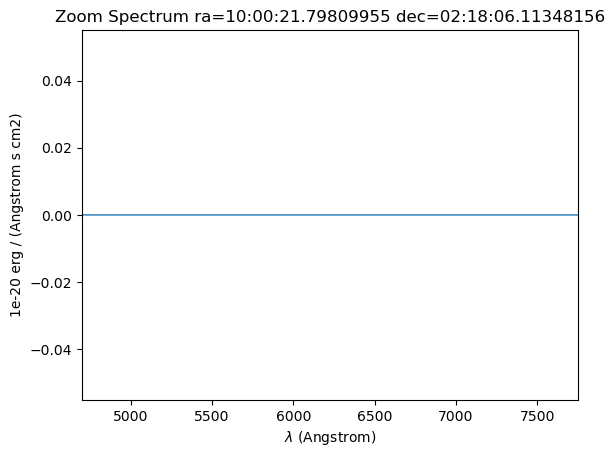

In [21]:
spe = cube[:, 0, 400]

import astropy.units as u

from mpdaf.obj import deg2sexa

coord_sky = cube.wcs.pix2sky([0, 400], unit=u.deg)

dec, ra = deg2sexa(coord_sky)[0]

plt.figure()


spe.plot(title = 'Spectrum ra=%s dec=%s' %(ra, dec))

plt.figure()


spe[0:2440].plot(title = 'Zoom Spectrum ra=%s dec=%s' %(ra, dec))

In [41]:
print(cube.get_step(unit_wave=u.AA, unit_wcs=u.deg))
print(cube.get_range(unit_wave=u.AA, unit_wcs=u.deg))
print(cube.get_start(unit_wave=u.AA, unit_wcs=u.deg), cube.get_end(unit_wave=u.AA, unit_wcs=u.deg))


[1.25000000e+00 5.55555556e-05 5.55555556e-05]
[4.70032715e+03 2.30169818e+00 1.50090380e+02 9.35157715e+03
 2.32447596e+00 1.50113066e+02]
[4.70032715e+03 2.30169818e+00 1.50113066e+02] [9.35157715e+03 2.32447596e+00 1.50090380e+02]


In [124]:
import numpy as np
from astropy.table import Table, Column, MaskedColumn, pprint
from astropy.io import fits
from astropy.wcs import WCS

with open('HST_WFC3_UVIS2.F606W.dat', 'r') as file:
    HST = file.read()


# Split the data into lines
HST = HST.split('\n')

# Split each line into columns and filter out any lines that don't have 2 columns
rows = [row.split() for row in HST if len(row.split()) == 2]

HST_table = Table(rows=rows, names=['Wavelength', 'Throughput'])

print(HST_table)


# Extract the wavelength values from the table and convert to float
wavelengths = np.array(HST_table['Wavelength'], dtype=float)

#Calculate the differences between consecutive wavelengths
wavelength_diffs = np.diff(wavelengths)

#Calculate the average, smallest, and largest step size
average_step = np.mean(wavelength_diffs)
smallest_step = np.min(wavelength_diffs)
largest_step = np.max(wavelength_diffs)

# Print the results
print("Average step size between wavelengths:", average_step)
print("Smallest step size between wavelengths:", smallest_step)
print("Largest step size between wavelengths:", largest_step)

 Wavelength  Throughput
----------- -----------
4579.000000 6.16977e-05
4580.000000 6.48326e-05
4581.000000  6.7968e-05
4581.283691 6.88576e-05
4582.000000 7.19065e-05
4583.000000 7.61635e-05
4584.000000 8.04211e-05
4585.000000 8.46792e-05
4586.000000 8.89456e-05
4587.000000 9.32053e-05
        ...         ...
7363.000000 6.90451e-05
7364.000000 6.80117e-05
7365.000000 6.69732e-05
7366.000000 6.59413e-05
7367.000000 6.49101e-05
7368.000000  6.3874e-05
7369.000000 6.28443e-05
7370.000000 6.18098e-05
7371.000000 6.07816e-05
7372.000000 5.97488e-05
7372.030273 5.97177e-05
Length = 3074 rows
Average step size between wavelengths: 0.90889367816466
Smallest step size between wavelengths: 0.00048799999967741314
Largest step size between wavelengths: 1.0


In [34]:
# Convert the 'Wavelength' column to float
HST_table['Wavelength'] = HST_table['Wavelength'].astype(float)

# Now perform the comparison and create the sub_table
sub_table = HST_table[(HST_table['Wavelength'] >= 5000) & (HST_table['Wavelength'] <= 6000)]
print(sub_table)


Wavelength Throughput
---------- ----------
    5000.0   0.284111
    5001.0   0.284532
5001.39502   0.284698
    5002.0      0.285
    5003.0   0.285498
    5004.0   0.285997
    5005.0   0.286496
    5006.0   0.286995
    5007.0   0.287494
    5008.0   0.287993
       ...        ...
    5991.0   0.284277
5991.65918   0.284294
    5992.0   0.284275
    5993.0   0.284241
    5994.0   0.284208
    5995.0   0.284175
    5996.0   0.284142
    5997.0   0.284109
    5998.0   0.284076
    5999.0   0.284019
    6000.0   0.283986
Length = 1101 rows


[ -97.06171875  -96.26171875  -95.46171875 ... 2136.53828125 2137.33828125
 2137.36249965]
[ -97  -96  -95 ... 2137 2137 2137]
Len(k): 2138
133
3074
Subcube k start: 4700.3271484375
Subcube k stop: 7371.5771484375


<function matplotlib.pyplot.figure(num: 'int | str | Figure | SubFigure | None' = None, figsize: 'tuple[float, float] | None' = None, dpi: 'float | None' = None, *, facecolor: 'ColorType | None' = None, edgecolor: 'ColorType | None' = None, frameon: 'bool' = True, FigureClass: 'type[Figure]' = <class 'matplotlib.figure.Figure'>, clear: 'bool' = False, **kwargs) -> 'Figure'>

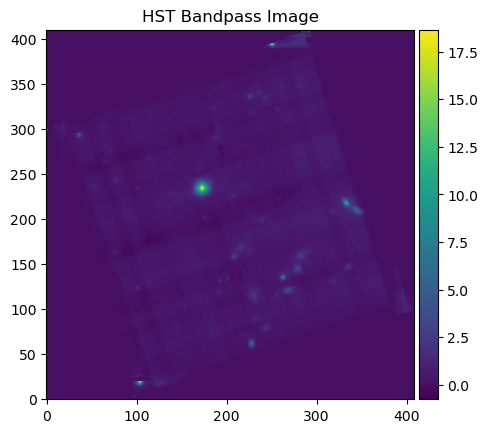

In [130]:



im4 = bandpass_image(cube, HST_table['Wavelength'], HST_table['Throughput']) ## Is the throughput actually good to use for sensitvities 



im4.plot(colorbar='v', title = 'HST Bandpass Image')

plt.figure

# This has limited the wavelength range of the cube to the HST filter range



In [121]:
cube_k = cube.wave.coord()

HST_k = np.array(HST_table['Wavelength']).astype(float)
HST_w = np.array(HST_table['Throughput']).astype(float)

cube_k

array([4700.32714844, 4701.57714844, 4702.82714844, ..., 9349.07714844,
       9350.32714844, 9351.57714844])

In [53]:


cube_lim = cube.select_lambda(5001, 6000)
print(cube_lim.get_range(unit_wave=u.AA, unit_wcs=u.deg))
print(cube_lim.get_start(unit_wave=u.AA, unit_wcs=u.deg), cube_lim.get_end(unit_wave=u.AA, unit_wcs=u.deg))
print(cube_lim.get_step(unit_wave=u.AA, unit_wcs=u.deg))



[5.00032715e+03 2.30169818e+00 1.50090380e+02 5.99907715e+03
 2.32447596e+00 1.50113066e+02]
[5.00032715e+03 2.30169818e+00 1.50113066e+02] [5.99907715e+03 2.32447596e+00 1.50090380e+02]
[1.25000000e+00 5.55555556e-05 5.55555556e-05]


In [ ]:
average_step = np.mean(wavelength_diffs)
average_step
